### This script contains the following points:
#### Section 0. Cleaning and Wrangling the summits.csv dataset

#### Section 1. Importing Libraries, Defining Project Path, Importing Dataset as "data"

#### Section 2. Resetting the "date" column as the index

#### Section 3. Creating a line chart of the data

#### Section 4. Decomposing the data's components

#### Section 5. Conducting a Dickey-Fuller test to check for stationarity and checking data's autocorrelations

#### Section 6. Conducting a round of differencing to see impact on Dickey-Fuller test


## Section 0. Cleaning and Wrangling the summits.csv dataset

Note: For this time series data, I'm using a <b>new data "summiters.csv" from the same data source in Kaggle</b> to see the number of summits that have occured quarterly from 1990 - 2019 (I've chosen this time period to match the 30 year time period done previously in this project). Each record represents a climber that has summitted, so I've done a count of records for each quarter to get my time series data. 

Please refer to script "2a. PART III Cleaning summiters.csv" to see notes on the wrangling steps (done in Excel) and the inital cleaning steps (done in Python).

Please refer to task 6.1 to see more information about how "summiters.csv" was sourced.

## Section 1. Importing Libraries, Defining Project Path, Importing Dataset as "data"

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Ensuring charts created are displayed in the notebook without the need to "call" them specifically.
%matplotlib inline

In [3]:
# Defining project folder path
path = r'C:\Users\prena\05-2023 Himalayan Expeditions Analysis'

In [4]:
# Importing expeditions.csv dataset
data = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'summits_30yrs_quarterly.csv'), index_col = False)

In [5]:
pd.set_option('display.max_columns',None)

In [6]:
pd.set_option('display.max_rows',None)

In [7]:
data.head()

,date,summits
0,03/01/1990,0
1,06/01/1990,95
2,09/01/1990,28
3,12/01/1990,190
4,03/01/1991,0


In [8]:
data.shape

(122, 2)

In [9]:
data.dtypes

date       object
summits     int64
dtype: object

## Section 2. Resetting the "date" column as the index

In [10]:
# Setting the date as the index
from datetime import datetime
data['datetime'] = pd.to_datetime(data['date'])
data = data.set_index('datetime')
data.drop(['date'], axis=1, inplace=True)
data.head()

,summits
datetime,
1990-03-01,0
1990-06-01,95
1990-09-01,28
1990-12-01,190
1991-03-01,0


## Section 3. Creating a line chart of the data

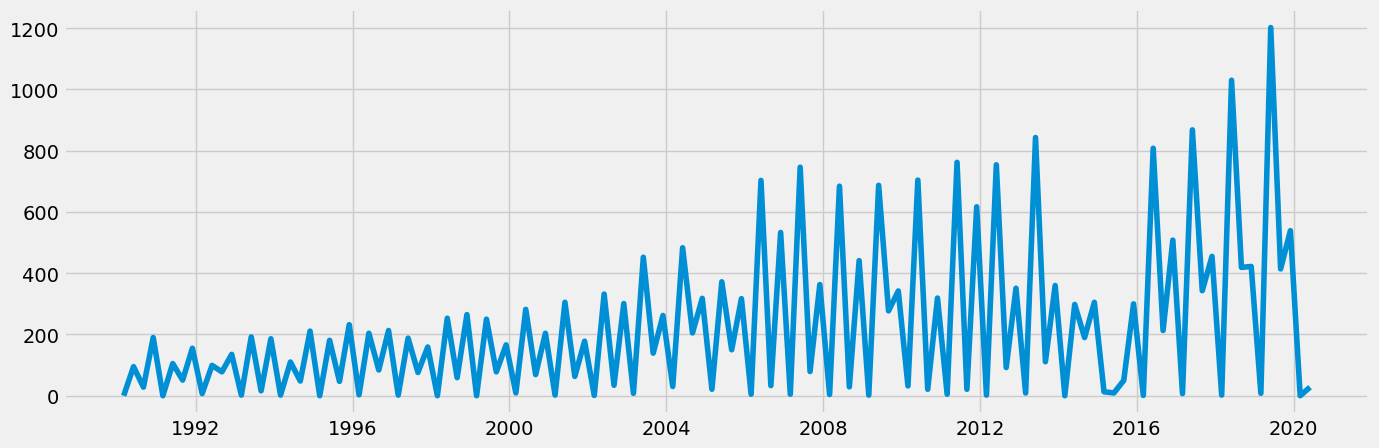

In [12]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

In [13]:
# Check for missing values (you shouldn't have any)

data.isnull().sum() 

summits    0
dtype: int64

## Section 4. Decomposing the data's components

In [15]:
decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [16]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

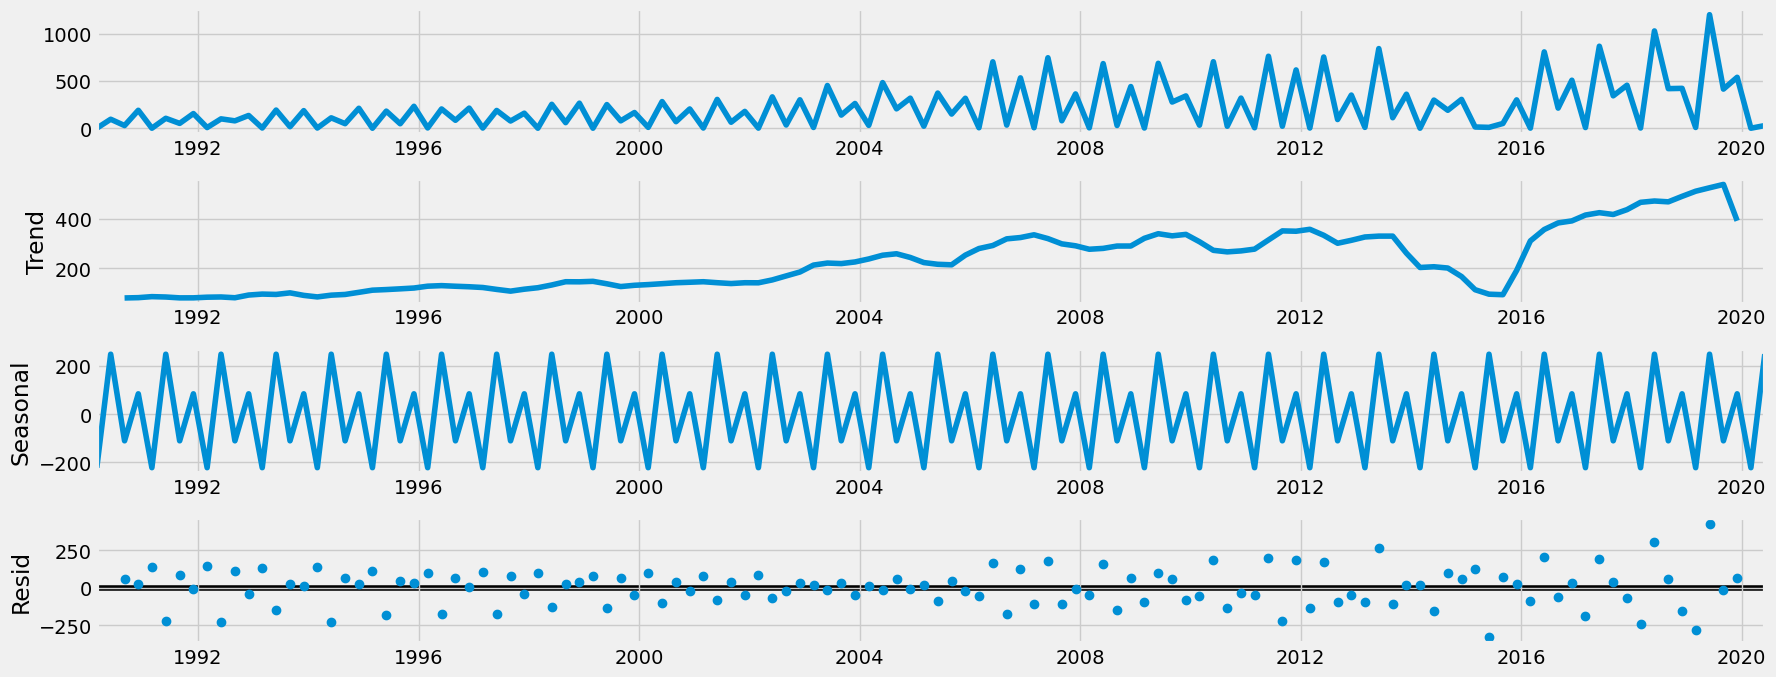

In [17]:
# Plot the separate components

decomposition.plot()
plt.show()

- The first line graph above is the <b>level</b> and shows us the data itself. From this, we can see that there are peaks and valleys across the data each year.

- The second line graph is showing us the underlying <b>trend</b>.The number of summits looks to increase up until 2012, and then decrease leading up to 2015. After 2015, we start to see an upwards trend again until 2019 where there is a sudden drop.

- The third line graph is showing us the <b>seasonality</b>. We can see that seasonality is present in our data, and there looks to be a pattern of a peak (no pun intended!), a subpeak, and finally, a valley.

- The fourth component is showing us the <b>residual</b>. This represents our data after the trend and seasonality has been removed. This noise looks to be pretty random so may be hard to explain (maybe these would be reduced if we removed outliers in the data, but I wanted to avoid this for this exercise as to see how the data behaved, first).

## Section 5. Conducting a Dickey-Fuller test to check for stationarity and checking data's autocorrelations

In [18]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data['summits'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.221810
p-value                          0.198425
Number of Lags Used              3.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


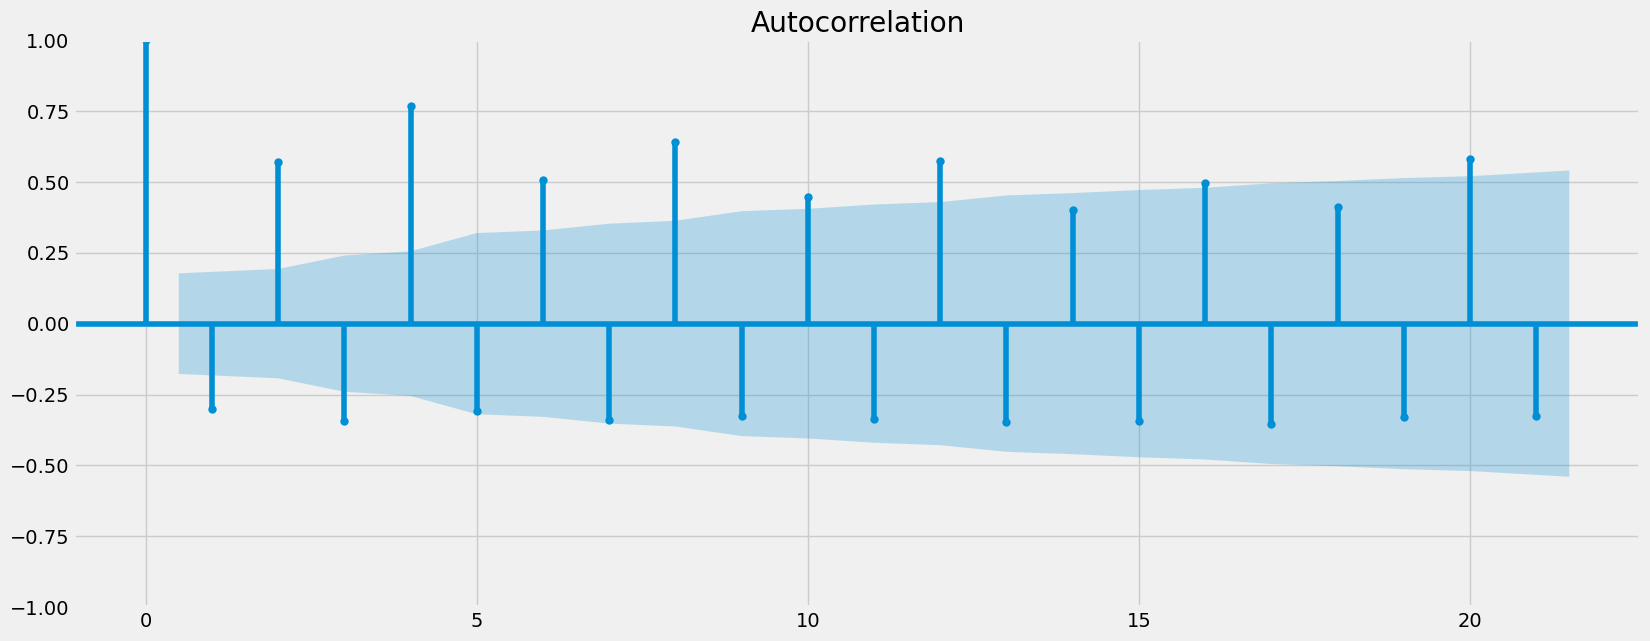

In [28]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data)
plt.show()

The Dickey-Fuller test has given us a test statistic of -2.22. Our test statistic is <b>smaller than all the critical values</b> at 1%, 5%, and 10% (these values are -3.48, -2.88, and -2.58). Because our test statistic is smaller than our critical values, we can reject the null hypothesis. In other words, we can conclude that there is NOT a unit root in our data, and our data is stationary.

However, looking at our p-value, or <b>p-value is greater than 0.05 at 0.198</b>. A significant result would be a p-value of less than 0.05. This is telling us that it is more likely that our results occured by random chance. This lessens the strength of our evidence against the null hypothesis. Because this is the case, I will go through a round of differencing to see what impacts differencing has on our test results.

Furthermore, our autocorrelation graph shows us that there are a few <b>lines that are outside our blue edge of the confidence level (about 10)</b>. There is a rule of thumb that you need at least 10 significant lags to declare a second differencing when you've already performed differencing. In this case, we haven't performed differencing yet, but this points to our data being stationary (but maybe perhaps weak).

## Section 6. Conducting a round of differencing to see impact on Dickey-Fuller test

In [20]:
data_diff = data - data.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [21]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [22]:
data_diff.head()

,summits
datetime,
1990-06-01,95.0
1990-09-01,-67.0
1990-12-01,162.0
1991-03-01,-190.0
1991-06-01,105.0


In [23]:
data_diff.columns

Index(['summits'], dtype='object')

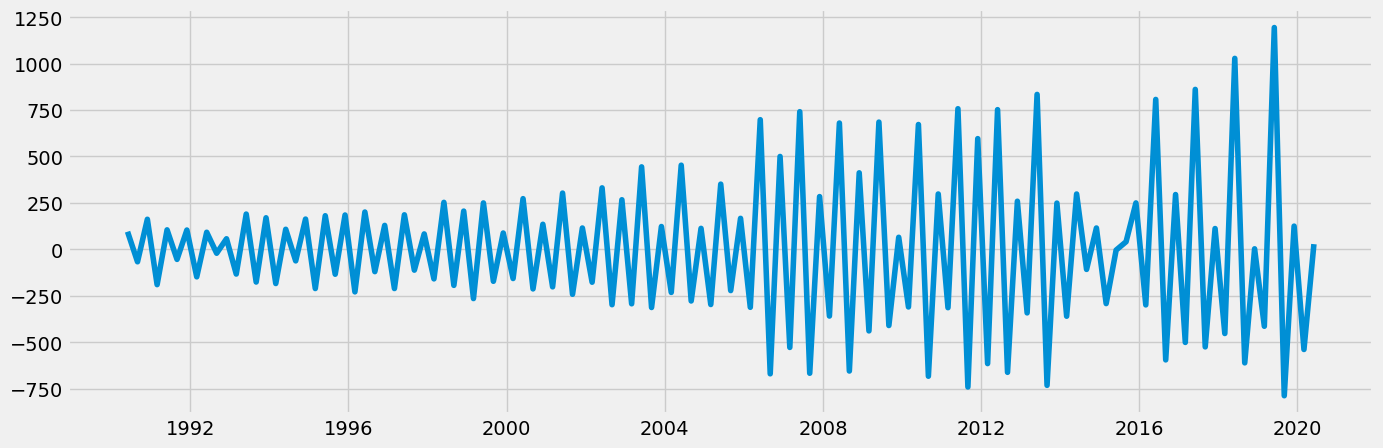

In [24]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [25]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.828594e+01
p-value                        2.302893e-30
Number of Lags Used            2.000000e+00
Number of Observations Used    1.180000e+02
Critical Value (1%)           -3.487022e+00
Critical Value (5%)           -2.886363e+00
Critical Value (10%)          -2.580009e+00
dtype: float64


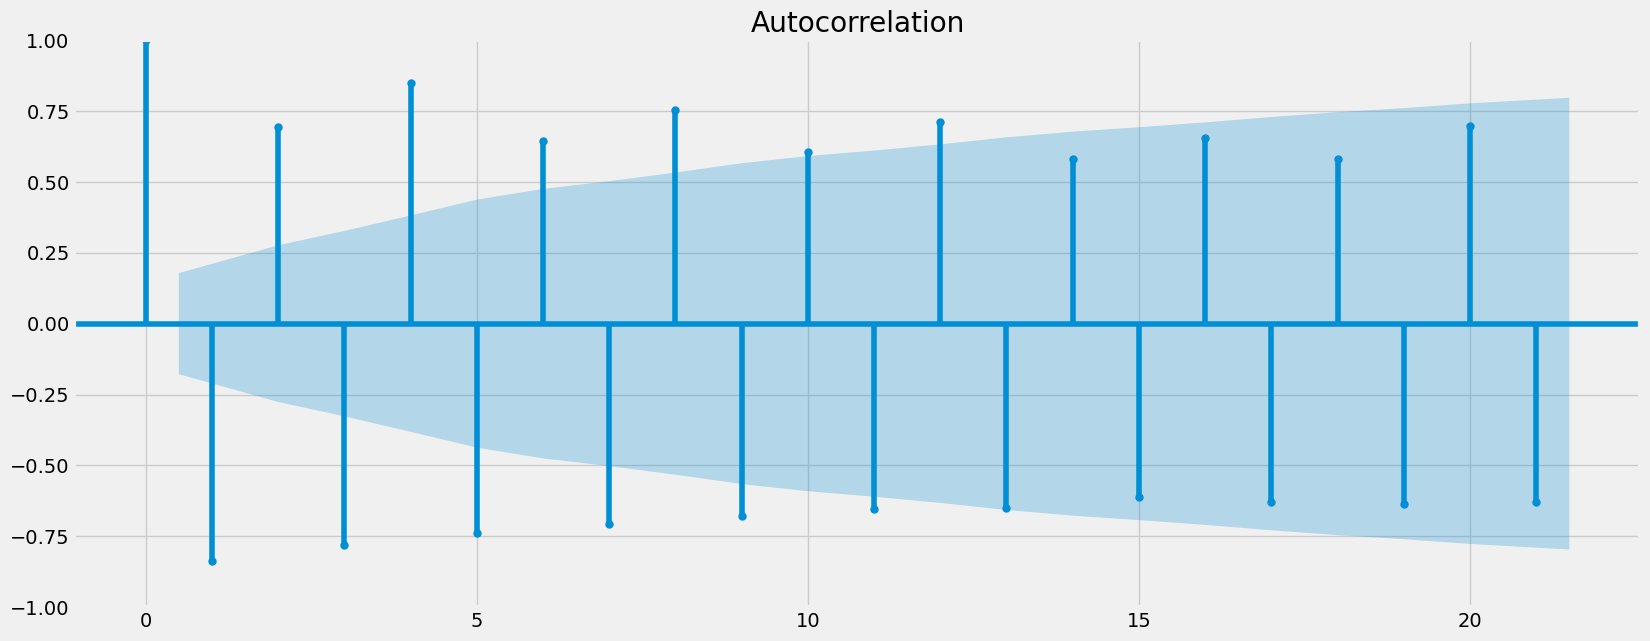

In [26]:
plot_acf(data_diff)
plt.show()

After performing a round of differencing, our test statistic is now at -18.29. This is significantly larger than our critical values. Next, our p-value is incredible small at 2.30e-30. Last, there are about 12 lines that are outside the blue edge of the confidence level suggesting that there are more autocorrelated terms). I think we may have over-differenced here! These numbers look a bit wacky, which means <b>we should've stopped after our first tests and concluded that our data is stationary!</b>